In [ ]:
!nvidia-smi

Sun Apr 27 05:55:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arjuntejaswi/plant-village")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plant-village


In [ ]:
!mkdir "PlantVillage"
!cp -r "/kaggle/input/plant-village" "/content/PlantVillage"
# !cp -r "/kaggle/input/plant-village/PlantVillage/Pepper__bell___healthy/" "/content/PlantVillage"

mkdir: cannot create directory ‘PlantVillage’: File exists


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Path to the original dataset
dataset_path = '/content/PlantVillage/plant-village/PlantVillage'

# Automatically detect class folders
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# Create train/val/test directories
for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(dataset_path, split, cls), exist_ok=True)

# Split ratios
train_ratio = 0.7  # 70% for training
val_ratio = 0.20   # 15% for validation
test_ratio = 0.10  # 15% for testing

# Split data for each class
for cls in classes:
    class_dir = os.path.join(dataset_path, cls)
    images = os.listdir(class_dir)

    # Filter image files only
    images = [img for img in images if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if len(images) == 0:
        print(f"⚠️ Skipping class '{cls}' - no images found.")
        continue

    # First split: separate train from the rest
    train_imgs, temp_imgs = train_test_split(images, train_size=train_ratio, random_state=42)

    # Second split: divide the rest into val and test
    val_imgs, test_imgs = train_test_split(temp_imgs,
                                          train_size=val_ratio/(val_ratio + test_ratio),
                                          random_state=42)

    # Move train images
    for img in train_imgs:
        src = os.path.join(class_dir, img)
        dst = os.path.join(dataset_path, 'train', cls, img)
        shutil.move(src, dst)

    # Move val images
    for img in val_imgs:
        src = os.path.join(class_dir, img)
        dst = os.path.join(dataset_path, 'val', cls, img)
        shutil.move(src, dst)

    # Move test images
    for img in test_imgs:
        src = os.path.join(class_dir, img)
        dst = os.path.join(dataset_path, 'test', cls, img)
        shutil.move(src, dst)

    # Try removing folder only if it's empty
    leftover = os.listdir(class_dir)
    if len(leftover) == 0:
        os.rmdir(class_dir)
    else:
        print(f"⚠️ Could not delete {class_dir} - directory not empty. Leftovers: {leftover}")

print("✅ Dataset successfully split into train/val/test folders.")


⚠️ Could not delete /content/PlantVillage/plant-village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus - directory not empty. Leftovers: ['svn-r6Yb5c']
✅ Dataset successfully split into train/val/test folders.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm.models.swin_transformer import SwinTransformer

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Data paths - update these to your Google Drive mounted locations
TRAIN_DIR = '/content/PlantVillage/plantvillage/PlantVillage/train'
VAL_DIR = '/content/PlantVillage/plantvillage/PlantVillage/val'

In [ ]:
# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 0.0001
IMAGE_SIZE = 224  # Swin Transformer typically uses 224x224 images


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:

val_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=VAL_DIR, transform=val_transforms)


FileNotFoundError: [Errno 2] No such file or directory: '/content/PlantVillage/plantvillage/PlantVillage/train'

In [ ]:
# Data paths
TRAIN_DIR = '/content/PlantVillage/plant-village/PlantVillage/train'
VAL_DIR = '/content/PlantVillage/plant-village/PlantVillage/val'
# TEST_DIR = '/content/PlantVillage/plant-village/PlantVillage/test'


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
# # Create test dataset with the same transformations as validation
# test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=val_transforms)

# # Create test dataloader
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Print dataset information
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
# print(f"Test samples: {len(test_dataset)}")


In [ ]:
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Class names: {train_dataset.classes}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


In [ ]:
# Create Swin Transformer model
def create_swin_model(num_classes):
    model = SwinTransformer(
        img_size=IMAGE_SIZE,
        patch_size=4,
        in_chans=3,
        num_classes=num_classes,
        embed_dim=96,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        window_size=7,
        mlp_ratio=4.,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.2,
    )
    return model

In [ ]:
model = create_swin_model(num_classes)
model = model.to(device)

In [ ]:
def get_model_summary(model):
    # Get total number of parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\nModel: {model.__class__.__name__}")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {total_params - trainable_params:,}")

    # Print model architecture
    print("\nModel Architecture:")
    print(model)

In [ ]:
!pip install torchinfo

In [ ]:
def get_detailed_summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE)):
    from torchinfo import summary
    model_stats = summary(model, input_size=input_size, depth=4,
                         col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"])
    print(model_stats)


In [ ]:
print("Basic Model Summary:")
get_model_summary(model)

print("\nDetailed Model Summary:")
get_detailed_summary(model)

Basic Model Summary:

Model: SwinTransformer
Total parameters: 27,548,576
Trainable parameters: 27,548,576
Non-trainable parameters: 0

Model Architecture:
SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)


In [ ]:
# Training function
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Calculate metrics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

In [ ]:
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Calculate metrics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

In [ ]:
# Lists to store metrics for plotting
train_losses = []
train_accs = []
val_losses = []
val_accs = []


In [ ]:
# Add this class before your training loop
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_val_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_val_loss - self.min_delta:
            self.best_val_loss = val_loss
            self.counter = 0
            return True  # Save model
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
            return False  # Don't save model


In [ ]:
# Initialize early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

# Lists to store metrics for plotting
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Training loop
start_time = time.time()
best_val_acc = 0.0


In [ ]:
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Update learning rate
    scheduler.step()

    # Print metrics
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_swin_plant_disease_model.pth')
        print("New best model saved!")

# Calculate training time
training_time = time.time() - start_time
print(f"\nTraining completed in {training_time/60:.2f} minutes")
print(f"Best validation accuracy: {best_val_acc:.4f}")


Epoch 1/20


Validation: 100%|██████████| 340/340 [00:50<00:00,  6.74it/s]


Train Loss: 1.2021, Train Acc: 0.6480
Val Loss: 0.5316, Val Acc: 0.8271
New best model saved!

Epoch 2/20


Validation: 100%|██████████| 340/340 [00:50<00:00,  6.76it/s]


Train Loss: 0.4726, Train Acc: 0.8508
Val Loss: 0.2899, Val Acc: 0.9055
New best model saved!

Epoch 3/20


Validation: 100%|██████████| 340/340 [00:50<00:00,  6.76it/s]


Train Loss: 0.3185, Train Acc: 0.8979
Val Loss: 0.2316, Val Acc: 0.9233
New best model saved!

Epoch 4/20


Validation: 100%|██████████| 340/340 [00:50<00:00,  6.76it/s]


Train Loss: 0.2298, Train Acc: 0.9266
Val Loss: 0.1618, Val Acc: 0.9448
New best model saved!

Epoch 5/20


Validation: 100%|██████████| 340/340 [00:50<00:00,  6.75it/s]


Train Loss: 0.1900, Train Acc: 0.9372
Val Loss: 0.1109, Val Acc: 0.9627
New best model saved!

Epoch 6/20


Validation: 100%|██████████| 340/340 [00:50<00:00,  6.75it/s]


Train Loss: 0.1543, Train Acc: 0.9493
Val Loss: 0.0822, Val Acc: 0.9733
New best model saved!

Epoch 7/20


Validation: 100%|██████████| 340/340 [00:50<00:00,  6.75it/s]


Train Loss: 0.1272, Train Acc: 0.9577
Val Loss: 0.0926, Val Acc: 0.9688

Epoch 8/20


Validation: 100%|██████████| 340/340 [00:50<00:00,  6.75it/s]


Train Loss: 0.1123, Train Acc: 0.9628
Val Loss: 0.0766, Val Acc: 0.9759
New best model saved!

Epoch 9/20


Validation: 100%|██████████| 340/340 [00:50<00:00,  6.77it/s]


Train Loss: 0.0908, Train Acc: 0.9707
Val Loss: 0.0527, Val Acc: 0.9829
New best model saved!

Epoch 10/20


Training:  90%|████████▉ | 1221/1358 [08:06<00:54,  2.51it/s]

Generating Confusion Matrix for the best model...


Evaluating Best Model: 100%|██████████| 129/129 [00:19<00:00,  6.60it/s]


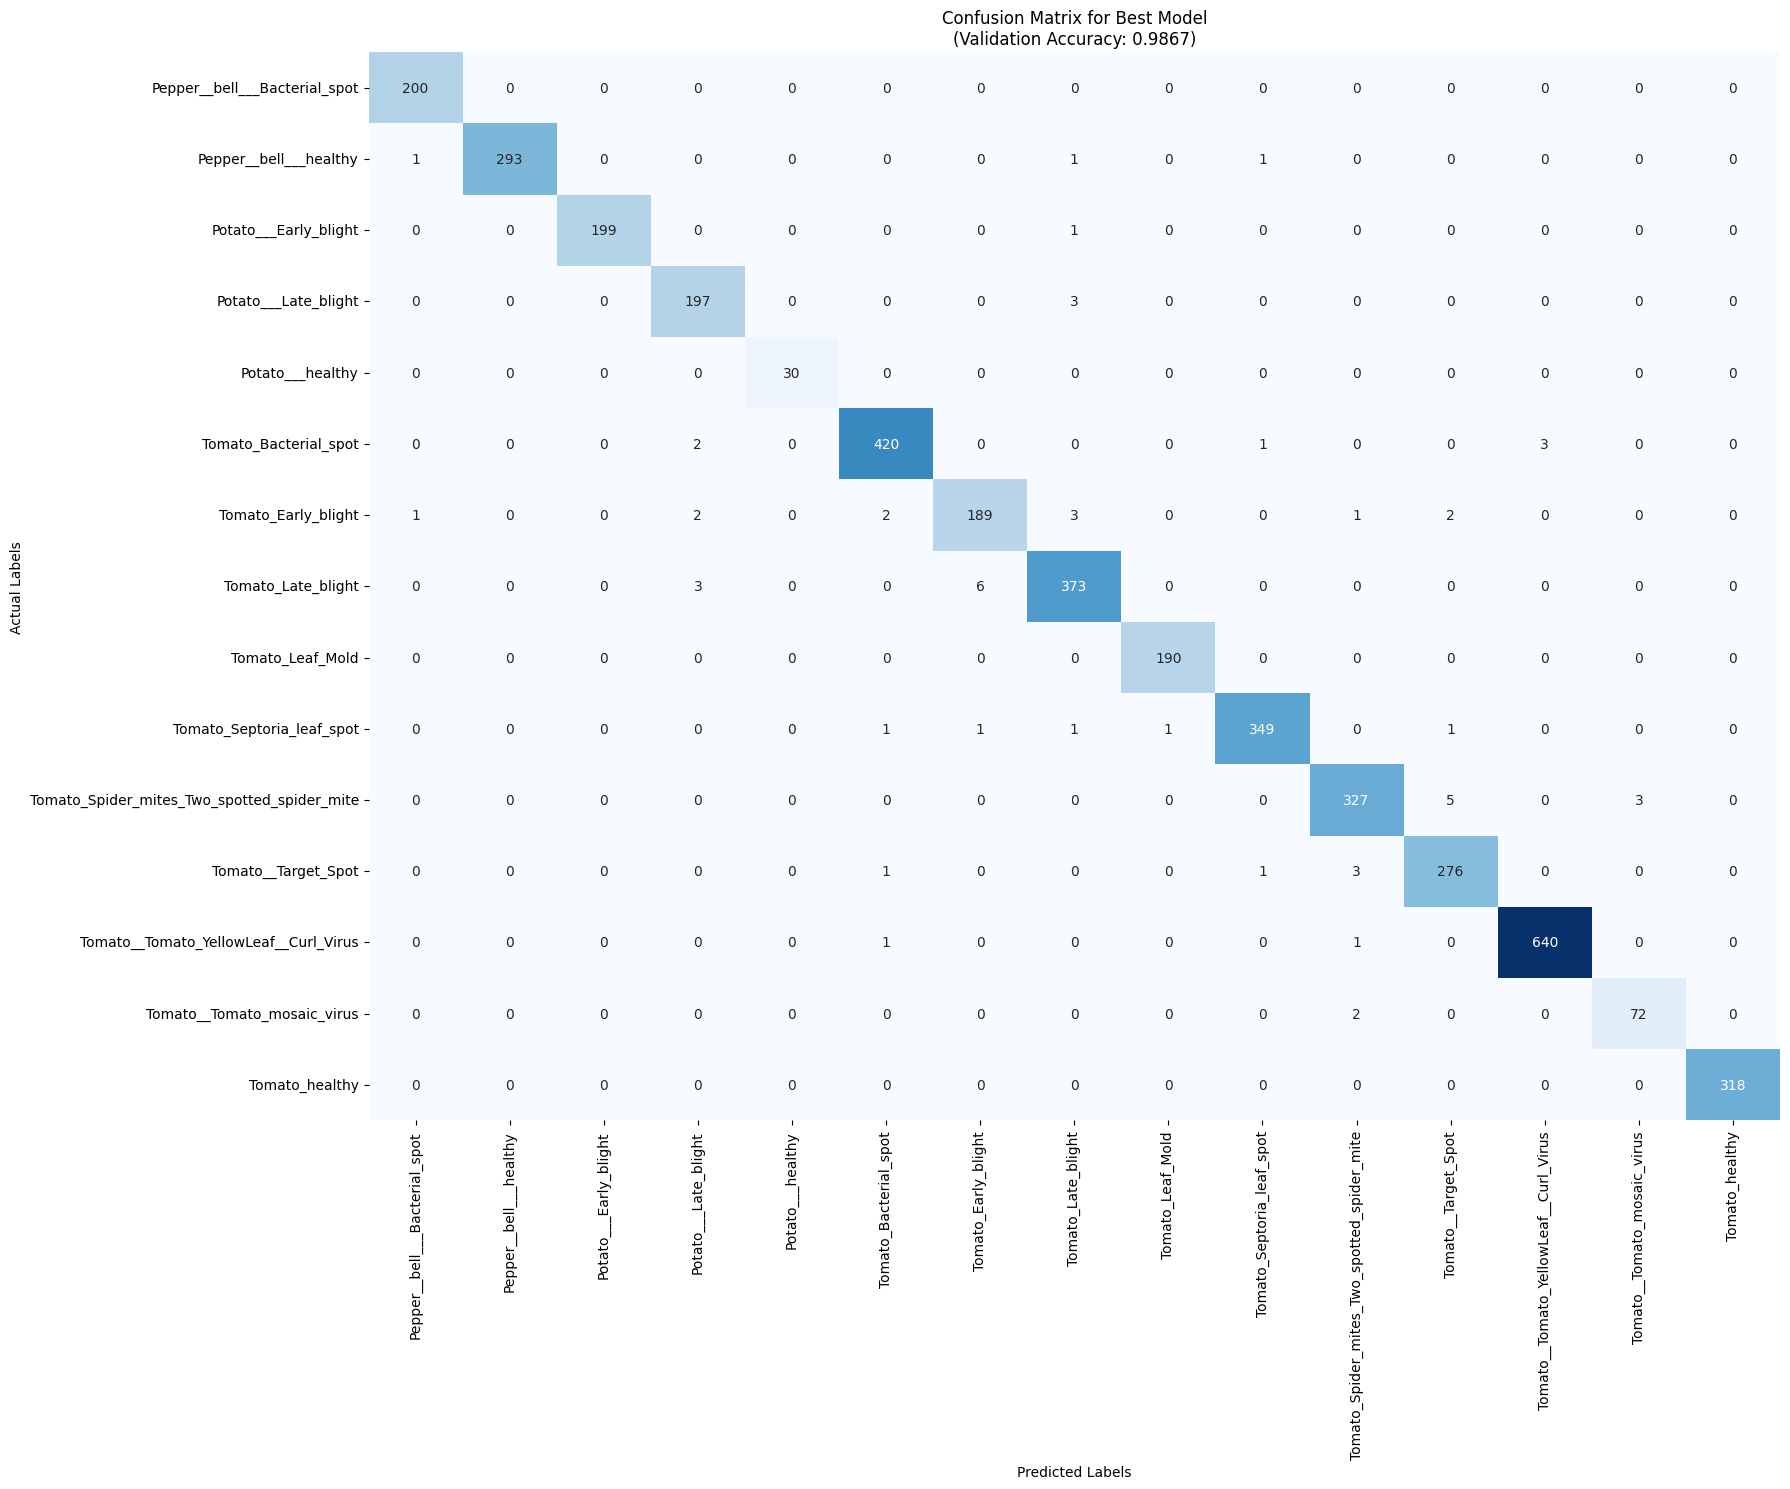

Confusion Matrix generation complete.


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

# --- Confusion Matrix for the Best Model ---

print("Generating Confusion Matrix for the best model...")

# 1. Load the best model
# Re-create the model architecture
best_model = create_swin_model(num_classes)
# Load the saved weights
best_model_path = 'best_swin_plant_disease_model.pth'
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)
best_model.eval() # Set the model to evaluation mode

# 2. Collect predictions and true labels from the validation set
all_preds = []
all_labels = []

with torch.no_grad(): # Disable gradient calculations
    for images, labels in tqdm(val_loader, desc="Evaluating Best Model"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 3. Compute and Plot the Confusion Matrix
class_names = val_dataset.classes # Get class names from the validation dataset

cm = confusion_matrix(all_labels, all_preds)

# # Plot using ConfusionMatrixDisplay (requires scikit-learn >= 0.22)
# plt.figure(figsize=(18, 16)) # Adjust figure size for better readability if many classes
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
# disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=plt.gca()) # Use plt.gca() to plot in current figure
# plt.title(f'Confusion Matrix for Best Model\n(Validation Accuracy: {best_val_acc:.4f})')
# plt.tight_layout() # Adjust layout
# plt.show()

# --- Optional: Plot using Seaborn (alternative visualization) ---
import pandas as pd
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(18, 15))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False) # fmt='d' for integer format
plt.title(f'Confusion Matrix for Best Model\n(Validation Accuracy: {best_val_acc:.4f})')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("Confusion Matrix generation complete.")



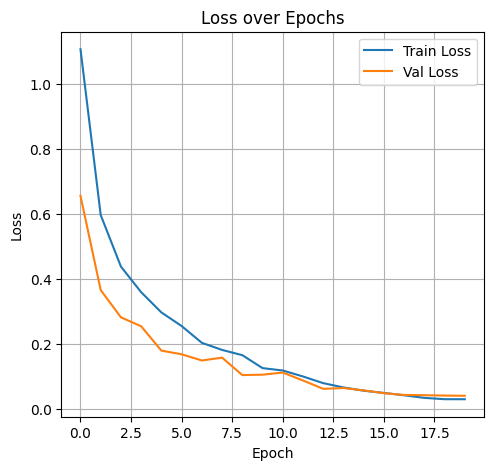

In [ ]:
# Plot the training and validation metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


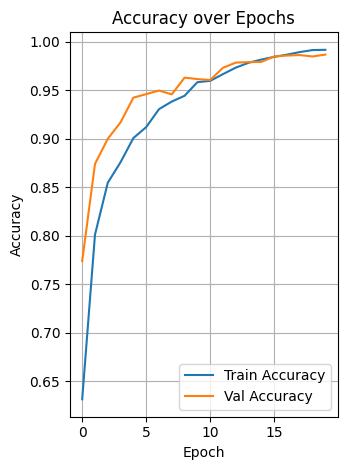

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Evaluating: 100%|██████████| 65/65 [00:10<00:00,  6.48it/s]


Test Loss: 0.0384, Test Accuracy: 0.9865


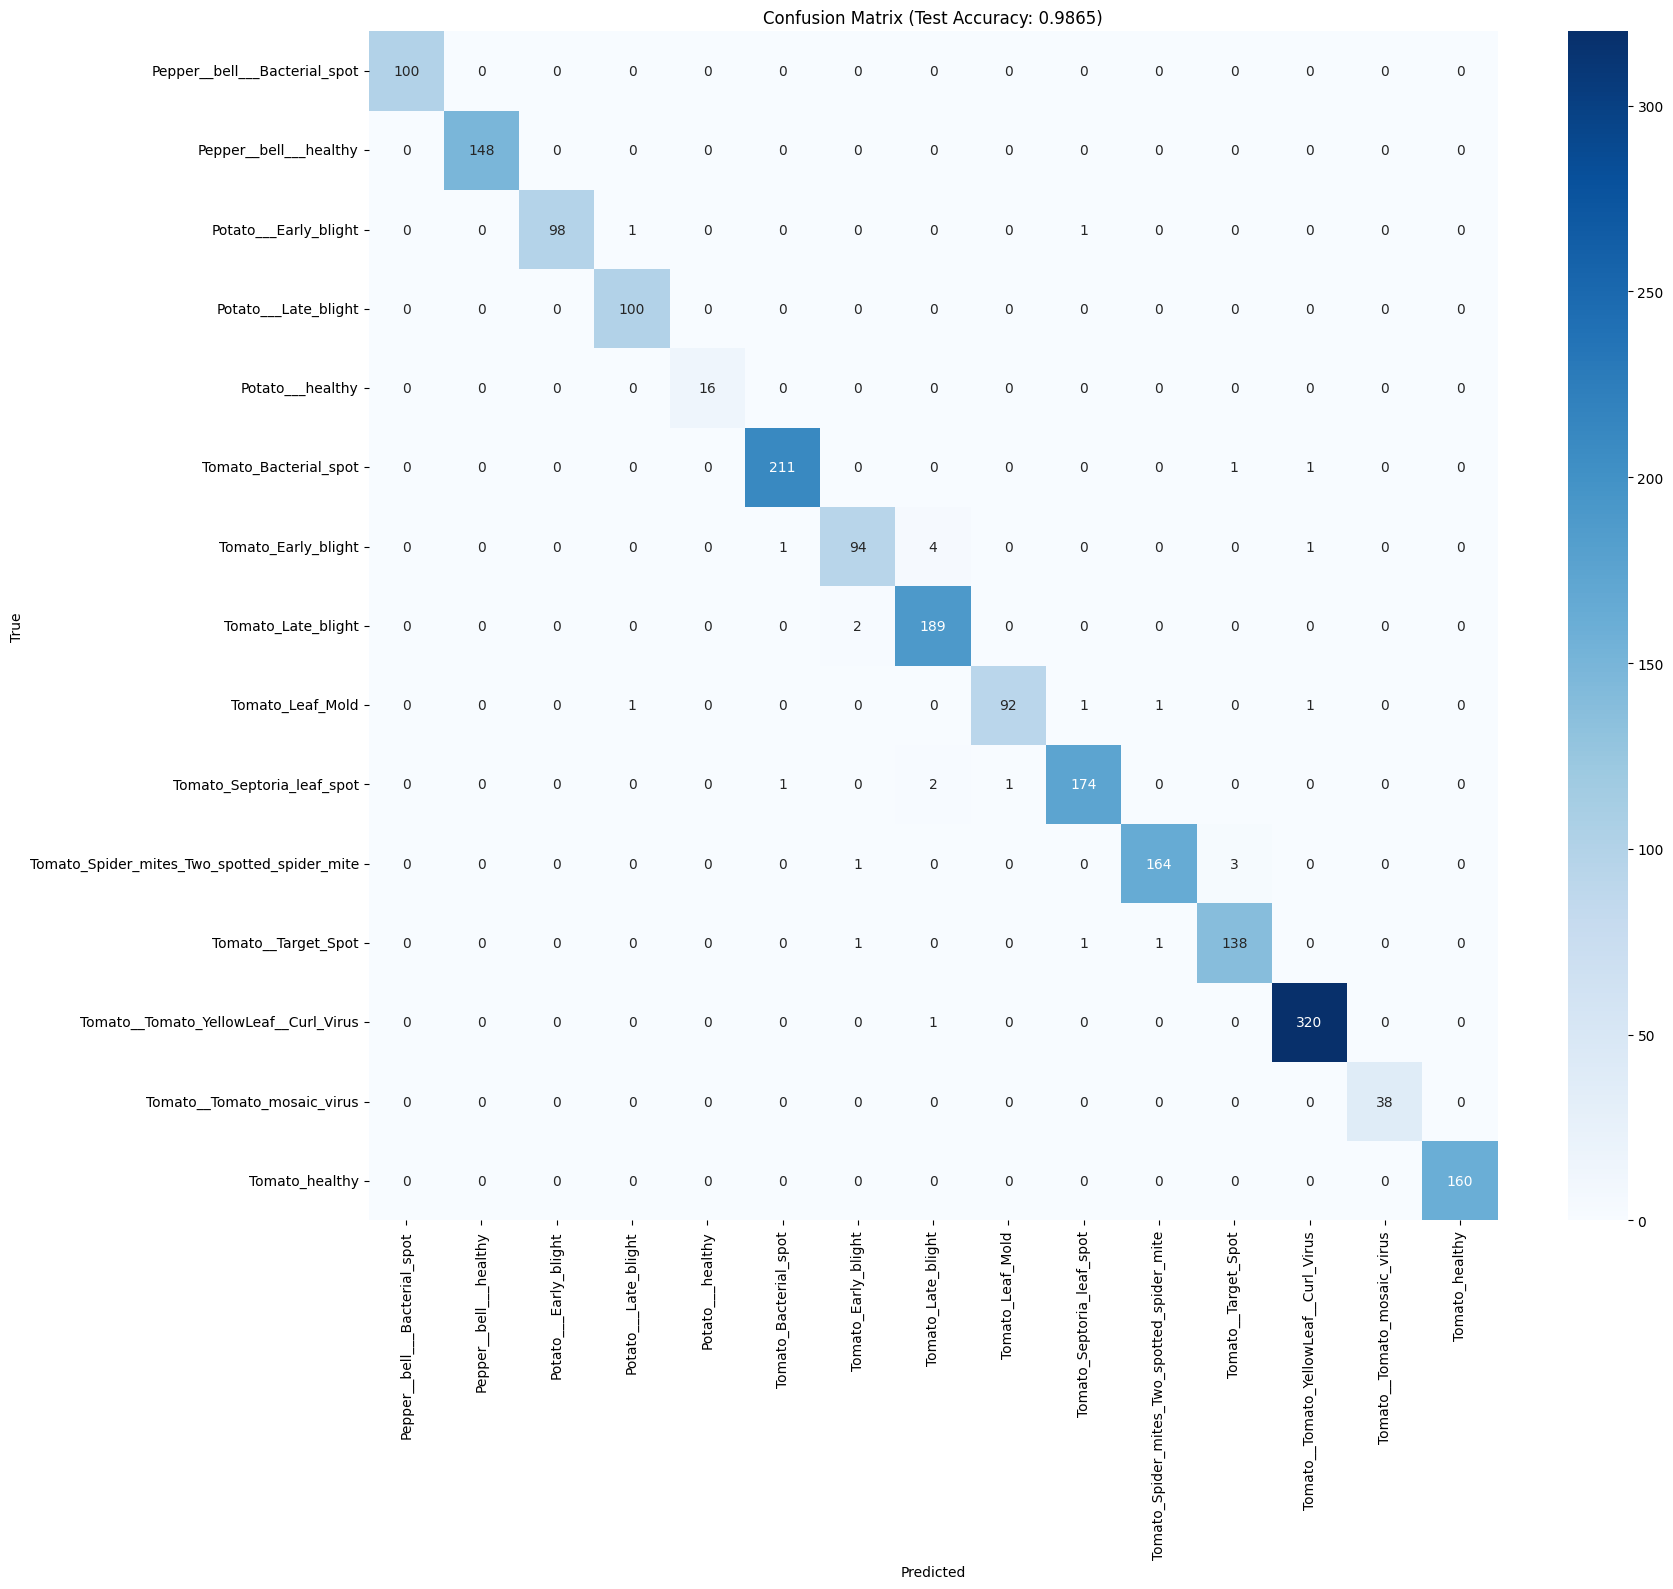


Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      1.00      1.00       100
                     Pepper__bell___healthy       1.00      1.00      1.00       148
                      Potato___Early_blight       1.00      0.98      0.99       100
                       Potato___Late_blight       0.98      1.00      0.99       100
                           Potato___healthy       1.00      1.00      1.00        16
                      Tomato_Bacterial_spot       0.99      0.99      0.99       213
                        Tomato_Early_blight       0.96      0.94      0.95       100
                         Tomato_Late_blight       0.96      0.99      0.98       191
                           Tomato_Leaf_Mold       0.99      0.96      0.97        96
                  Tomato_Septoria_leaf_spot       0.98      0.98      0.98       178
Tomato_Spider_mites_Two_spotted_spider_m

In [ ]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Calculate metrics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions and labels for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(dataloader.dataset)
    test_acc = correct / total

    return test_loss, test_acc, all_preds, all_labels

# Load the best model
best_model = create_swin_model(num_classes)
best_model.load_state_dict(torch.load('best_swin_plant_disease_model.pth'))
best_model = best_model.to(device)

# Evaluate on test set
test_loss, test_acc, all_preds, all_labels = evaluate_model(best_model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Create confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(18, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Test Accuracy: {test_acc:.4f})')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


In [ ]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [ ]:


import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from captum.attr import visualization as viz
from captum.attr import GradientShap, IntegratedGradients, GuidedGradCam, LayerGradCam

# Function to get transforms for visualization
def get_transforms():
    return transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Function to get a specific layer from model
def get_model_layer(model, layer_name):
    # Parse the layer name and access it programmatically
    parts = layer_name.split('.')
    curr_layer = model

    for part in parts:
        if part.isdigit():
            curr_layer = curr_layer[int(part)]
        else:
            curr_layer = getattr(curr_layer, part)

    return curr_layer

# Function to visualize Grad-CAM
def visualize_gradcam(model, img_path, target_layer='layers.3'):
    img = Image.open(img_path).convert('RGB')
    img_tensor = get_transforms()(img).unsqueeze(0).to(device)

    # Get the target layer
    try:
        # Try to access the layer directly
        target = get_model_layer(model, target_layer)
    except (AttributeError, IndexError) as e:
        print(f"Error accessing layer: {e}")
        print("Using last backbone layer as fallback")
        # Fallback to a commonly available layer
        target = model.layers[-1]

    # Create Layer GradCAM
    layer_gc = LayerGradCam(model, target)

    # Get class predictions
    with torch.no_grad():
        output = model(img_tensor)
        pred_class = torch.argmax(output, dim=1).item()
        pred_label = val_dataset.classes[pred_class]

    # Generate attribution
    attribution = layer_gc.attribute(img_tensor, target=pred_class)

    # Visualize
    original_img = np.array(img)

    # Handle different attribution shapes
    if len(attribution.shape) == 4:
        # If we have a 4D tensor [B, C, H, W], take the first image and average over channels
        attribution = attribution.cpu().detach().numpy()[0].mean(axis=0)
    else:
        attribution = attribution.cpu().detach().numpy()[0]

    # Resize attribution to match image size
    from scipy.ndimage import zoom
    zoom_factors = (img.height/attribution.shape[0], img.width/attribution.shape[1])
    attribution = zoom(attribution, zoom_factors)

    # Normalize
    attribution = (attribution - attribution.min()) / (attribution.max() - attribution.min() + 1e-8)

      # --- Plotting Section ---
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(original_img)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(original_img) # Show original image underneath
    # Increase alpha to make heatmap more prominent, try 'viridis' or 'inferno' cmap
    heatmap = axs[1].imshow(attribution, cmap='viridis', alpha=0.65) # <--- MODIFIED LINE (Increased alpha, changed cmap)
    axs[1].set_title(f'Grad-CAM: {pred_label}')
    axs[1].axis('off')

    plt.colorbar(heatmap, ax=axs[1]) # Add colorbar for reference
    plt.tight_layout()
    plt.show()
    # --- End Plotting Section ---


    return pred_label

In [ ]:
def visualize_integrated_gradients(model, img_path):
    img = Image.open(img_path).convert('RGB')
    img_tensor = get_transforms()(img).unsqueeze(0).to(device)

    # Get class predictions
    with torch.no_grad():
        output = model(img_tensor)
        pred_class = torch.argmax(output, dim=1).item()
        pred_label = val_dataset.classes[pred_class]

    # Configure Integrated Gradients
    ig = IntegratedGradients(model)

    try:
        # Generate attribution
        attributions, delta = ig.attribute(img_tensor, target=pred_class, return_convergence_delta=True)

        # Convert to numpy
        attributions = attributions.cpu().detach().numpy()[0]

        # Sum across RGB channels to get feature importance per pixel
        attr_sum = np.sum(abs(attributions), axis=0)

        # Visualize
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        axs[0].imshow(np.array(img))
        axs[0].set_title('Original Image')
        axs[0].axis('off')

        heatmap = axs[1].imshow(attr_sum, cmap='inferno')
        axs[1].set_title(f'Integrated Gradients: {pred_label}')
        axs[1].axis('off')

        plt.colorbar(heatmap, ax=axs[1])
        plt.tight_layout()
        plt.show()

        return pred_label

    except Exception as e:
        print(f"Error with Integrated Gradients: {e}")
        return pred_label

In [ ]:
def visualize_occlusion(model, img_path, occlusion_size=32, stride=8):
    """
    Visualize model's sensitivity to occlusion of different parts of the image
    """
    img = Image.open(img_path).convert('RGB')
    img_tensor = get_transforms()(img).unsqueeze(0).to(device)

    # Get original prediction
    with torch.no_grad():
        output = model(img_tensor)
        pred_class = torch.argmax(output, dim=1).item()
        pred_label = val_dataset.classes[pred_class]
        orig_conf = torch.nn.functional.softmax(output, dim=1)[0, pred_class].item()

    # Create occlusion map
    h, w = IMAGE_SIZE, IMAGE_SIZE
    occlusion_map = np.zeros((h, w))

    # Create a baseline (mean color) for occlusion
    baseline = torch.zeros_like(img_tensor)
    baseline[:, 0, :, :] = 0.485  # R mean
    baseline[:, 1, :, :] = 0.456  # G mean
    baseline[:, 2, :, :] = 0.406  # B mean

    # Compute occlusion sensitivities
    for y in range(0, h - occlusion_size + 1, stride):
        for x in range(0, w - occlusion_size + 1, stride):
            # Create occluded image
            occluded = img_tensor.clone()
            occluded[:, :, y:y+occlusion_size, x:x+occlusion_size] = baseline[:, :, y:y+occlusion_size, x:x+occlusion_size]

            # Get new prediction
            with torch.no_grad():
                output = model(occluded)
                conf = torch.nn.functional.softmax(output, dim=1)[0, pred_class].item()

            # Compute sensitivity (larger drops in confidence are more important)
            sensitivity = orig_conf - conf

            # Assign to occlusion map
            occlusion_map[y:y+occlusion_size, x:x+occlusion_size] += sensitivity

    # Normalize the occlusion map
    occlusion_map = (occlusion_map - occlusion_map.min()) / (occlusion_map.max() - occlusion_map.min() + 1e-8)

    # Visualize
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(np.array(img))
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(np.array(img))
    heatmap = axs[1].imshow(occlusion_map, cmap='jet', alpha=0.5)
    axs[1].set_title(f'Occlusion Sensitivity: {pred_label}')
    axs[1].axis('off')

    plt.colorbar(heatmap, ax=axs[1])
    plt.tight_layout()
    plt.show()

    return pred_label

In [ ]:
import shap

def visualize_shap(model, img_path, n_samples=50):
    img = Image.open(img_path).convert('RGB')
    img_tensor = get_transforms()(img).unsqueeze(0).to(device)

    # Get class predictions
    with torch.no_grad():
        output = model(img_tensor)
        pred_class = torch.argmax(output, dim=1).item()
        pred_label = val_dataset.classes[pred_class]

    # Create explainer
    explainer = shap.GradientExplainer(model, torch.zeros((1, 3, IMAGE_SIZE, IMAGE_SIZE)).to(device))

    # Get SHAP values
    shap_values = explainer.shap_values(img_tensor, nsamples=n_samples)

    # Plot SHAP values
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(img_tensor.cpu().numpy(), 1, -1), 1, 2)

    # Plot the feature attributions
    shap.image_plot(shap_numpy, -test_numpy)

    return pred_label

In [ ]:
def analyze_model_predictions(model, test_loader, num_samples=5):
    """
    Function to analyze model predictions on test data
    """
    model.eval()
    images, labels = [], []
    true_labels, pred_labels = [], []

    # Get some test images
    dataiter = iter(test_loader)
    for i in range(num_samples):
        img, label = next(dataiter)
        images.append(img[0])
        labels.append(label[0].item())

        # Get prediction
        with torch.no_grad():
            output = model(img.to(device))
            pred = torch.argmax(output, dim=1).item()
            true_labels.append(val_dataset.classes[label[0].item()])
            pred_labels.append(val_dataset.classes[pred])

    # Visualize predictions
    fig, axs = plt.subplots(num_samples, 2, figsize=(12, 3*num_samples))

    for i in range(num_samples):
        # Original image
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        axs[i, 0].imshow(img)
        axs[i, 0].set_title(f"True: {true_labels[i]}")
        axs[i, 0].axis('off')

        # GradCAM
        img_tensor = images[i].unsqueeze(0).to(device)

        # Get a suitable layer for GradCAM - adjust as needed
        layer_gc = LayerGradCam(model, model.layers[3])

        attribution = layer_gc.attribute(img_tensor, target=labels[i])
        attribution = attribution.cpu().detach().numpy()[0, 0]

        # Resize attribution to match image size
        from scipy.ndimage import zoom
        attribution = zoom(attribution, (IMAGE_SIZE/attribution.shape[0], IMAGE_SIZE/attribution.shape[1]))

        # Normalize
        attribution = (attribution - attribution.min()) / (attribution.max() - attribution.min())

        # Show with heatmap
        axs[i, 1].imshow(img)
        axs[i, 1].imshow(attribution, cmap='jet', alpha=0.5)
        axs[i, 1].set_title(f"Pred: {pred_labels[i]}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def analyze_class_features(model, dataset, class_idx=None, num_samples=10):
    """
    Analyze which features are most important for a specific class
    """
    if class_idx is None:
        # Select a random class
        class_idx = np.random.randint(0, len(dataset.classes))

    class_name = dataset.classes[class_idx]
    print(f"Analyzing features for class: {class_name}")

    # Get samples from this class
    class_samples = []
    class_indices = [i for i, (_, label) in enumerate(dataset) if label == class_idx]

    if len(class_indices) < num_samples:
        num_samples = len(class_indices)

    selected_indices = np.random.choice(class_indices, num_samples, replace=False)

    attributions_sum = None

    for idx in selected_indices:
        img, _ = dataset[idx]
        img_tensor = img.unsqueeze(0).to(device)

        # Use Integrated Gradients
        ig = IntegratedGradients(model)
        attributions, _ = ig.attribute(img_tensor, target=class_idx, return_convergence_delta=True)
        attributions = attributions.cpu().detach().numpy()[0]

        # Sum across RGB channels to get feature importance per pixel
        attr_sum = np.sum(abs(attributions), axis=0)

        if attributions_sum is None:
            attributions_sum = attr_sum
        else:
            attributions_sum += attr_sum

    # Average across samples
    attributions_avg = attributions_sum / num_samples

    # Visualize average attribution map
    plt.figure(figsize=(8, 6))
    plt.imshow(attributions_avg, cmap='inferno')
    plt.title(f'Average Feature Importance for {class_name}')
    plt.colorbar()
    plt.axis('off')
    plt.show()

In [ ]:
def explain_decision(model, img_path):
    """
    Provide a comprehensive explanation of a model's decision
    """
    img = Image.open(img_path).convert('RGB')
    img_tensor = get_transforms()(img).unsqueeze(0).to(device)

    # Get prediction
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)[0]
        pred_class = torch.argmax(output, dim=1).item()
        pred_label = val_dataset.classes[pred_class]

    # Get top 3 predictions
    top_probs, top_classes = torch.topk(probabilities, 3)
    top_probs = top_probs.cpu().numpy()
    top_classes = top_classes.cpu().numpy()

    # Display image and predictions
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Show prediction probabilities as bar chart
    plt.subplot(1, 2, 2)
    bars = plt.bar(range(3), top_probs * 100)
    plt.xticks(range(3), [val_dataset.classes[i] for i in top_classes], rotation=45, ha='right')
    plt.ylabel('Probability (%)')
    plt.title('Top 3 Predictions')

    # Add percentage labels
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f"{top_probs[i]*100:.1f}%", ha='center')

    plt.tight_layout()
    plt.show()

    # Generate Grad-CAM visualization
    target_layer = model.layers[3]  # Using the last transformer block
    layer_gc = LayerGradCam(model, target_layer)
    attribution = layer_gc.attribute(img_tensor, target=pred_class)

    attribution = attribution.cpu().detach().numpy()[0, 0]

    # Resize attribution to match image size
    from scipy.ndimage import zoom
    attribution = zoom(attribution, (img.height/attribution.shape[0], img.width/attribution.shape[1]))

    # Normalize
    attribution = (attribution - attribution.min()) / (attribution.max() - attribution.min())

    # Display heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(np.array(img))
    plt.imshow(attribution, cmap='jet', alpha=0.5)
    plt.title(f'Model Focus Areas for Prediction: {pred_label}')
    plt.axis('off')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    # Generate textual explanation
    print(f"The model predicts this image as '{pred_label}' with {top_probs[0]*100:.1f}% confidence.")

    if top_probs[0] > 0.9:
        confidence = "very high"
    elif top_probs[0] > 0.7:
        confidence = "high"
    elif top_probs[0] > 0.5:
        confidence = "moderate"
    else:
        confidence = "low"

    print(f"This is a {confidence} confidence prediction.")

    # Alternative predictions
    if top_probs[1] > 0.2:
        print(f"The model also considered '{val_dataset.classes[top_classes[1]]}' ({top_probs[1]*100:.1f}%) as a possibility.")

    return pred_label

In [ ]:
def print_model_structure(model, max_depth=3, prefix=''):
    """
    Print the structure of the model to identify appropriate layers for Grad-CAM
    """
    if max_depth <= 0:
        return

    for name, module in model._modules.items():
        if module is None:
            continue

        print(f"{prefix}{name}: {type(module).__name__}")

        if len(list(module.children())) > 0:
            print_model_structure(module, max_depth-1, prefix + '  ')

# Use this to identify proper layers
print_model_structure(model)

patch_embed: PatchEmbed
  proj: Conv2d
  norm: LayerNorm
layers: Sequential
  0: SwinTransformerStage
    downsample: Identity
    blocks: Sequential
  1: SwinTransformerStage
    downsample: PatchMerging
    blocks: Sequential
  2: SwinTransformerStage
    downsample: PatchMerging
    blocks: Sequential
  3: SwinTransformerStage
    downsample: PatchMerging
    blocks: Sequential
norm: LayerNorm
head: ClassifierHead
  global_pool: SelectAdaptivePool2d
    pool: FastAdaptiveAvgPool
    flatten: Identity
  drop: Dropout
  fc: Linear
  flatten: Identity


Demonstrating XAI Techniques:

1. Grad-CAM Visualization


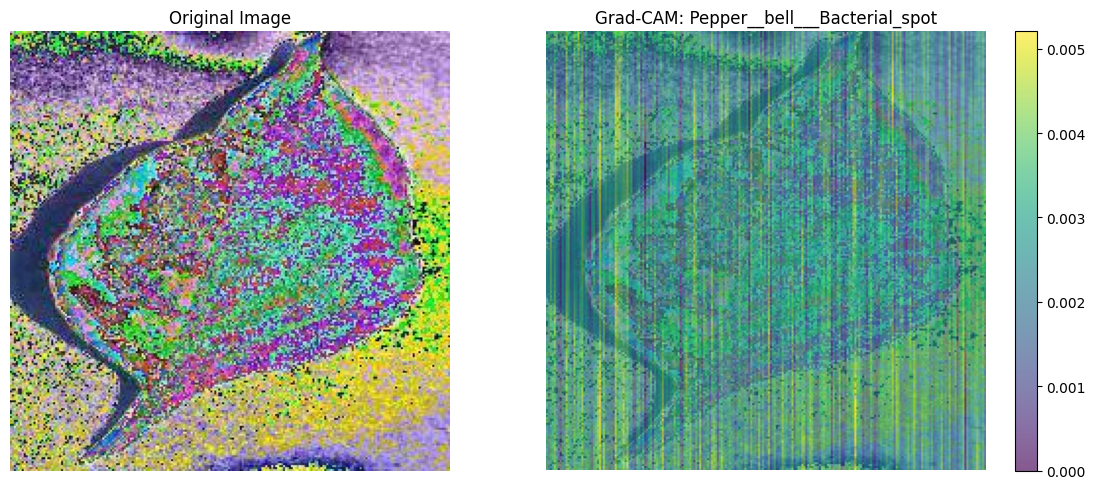

Predicted class: Pepper__bell___Bacterial_spot

2. Integrated Gradients Visualization


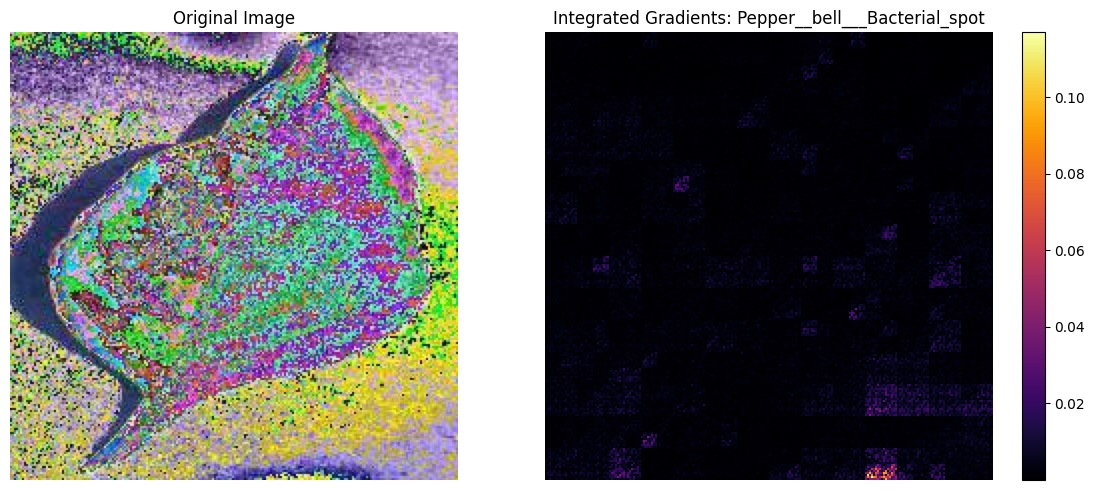

Predicted class: Pepper__bell___Bacterial_spot

3. Occlusion Sensitivity Analysis


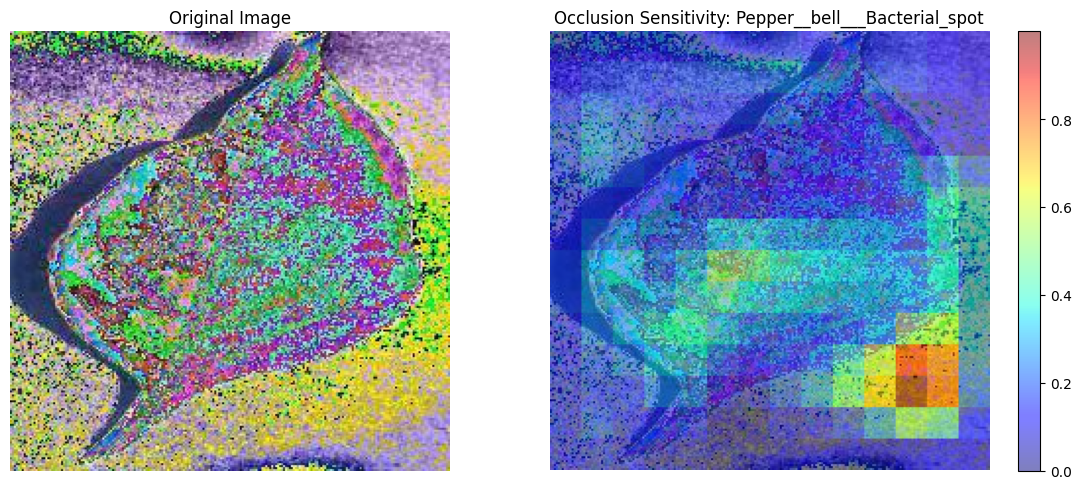

Predicted class: Pepper__bell___Bacterial_spot


In [ ]:

print("Demonstrating XAI Techniques:")

# Get a test image from the validation set
val_dataiter = iter(val_loader)
images, labels = next(val_dataiter)
img_tensor = images[0]

# Convert tensor to PIL Image for visualization
from torchvision.transforms.functional import to_pil_image
img = to_pil_image(img_tensor)

# Save the image temporarily
img_path = 'temp_image.jpg'
img.save(img_path)

print("\n1. Grad-CAM Visualization")
try:
    pred_label = visualize_gradcam(model, img_path)
    print(f"Predicted class: {pred_label}")
except Exception as e:
    print(f"Error with Grad-CAM: {e}")

print("\n2. Integrated Gradients Visualization")
try:
    pred_label = visualize_integrated_gradients(model, img_path)
    print(f"Predicted class: {pred_label}")
except Exception as e:
    print(f"Error with Integrated Gradients: {e}")

print("\n3. Occlusion Sensitivity Analysis")
try:
    pred_label = visualize_occlusion(model, img_path, occlusion_size=32, stride=16)
    print(f"Predicted class: {pred_label}")
except Exception as e:
    print(f"Error with Occlusion Analysis: {e}")

In [ ]:
def visualize_swin_attention_windows(model, img_path):
    """
    Advanced visualization of Swin Transformer's window-based attention
    """
    img = Image.open(img_path).convert('RGB')
    img_tensor = get_transforms()(img).unsqueeze(0).to(device)

    # Get prediction
    with torch.no_grad():
        output = model(img_tensor)
        pred_class = torch.argmax(output, dim=1).item()
        pred_label = val_dataset.classes[pred_class]

    # Store feature maps and attention maps
    feature_maps = []
    attention_maps = []

    # Define hooks to capture intermediate outputs
    def feature_hook(module, input, output):
        if isinstance(output, torch.Tensor):
            feature_maps.append(output.detach().cpu())

    def attention_hook(module, input, output):
        # Try to access attention scores if they exist
        if hasattr(module, 'attn_probs') and module.attn_probs is not None:
            attention_maps.append(module.attn_probs.detach().cpu())

        # For window attention modules that compute attention inline
        elif hasattr(module, 'qkv') and hasattr(module, 'attn_drop'):
            # We need to recompute attention here
            # This is a sketch - implementation details depend on the exact model
            # H = W = self.window_size
            # B, N, C = x.shape
            # qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
            # q, k, v = qkv[0], qkv[1], qkv[2]
            # attn = (q @ k.transpose(-2, -1)) * self.scale
            # attn = attn.softmax(dim=-1)

            # For now, we'll just capture the feature maps
            if isinstance(output, torch.Tensor):
                feature_maps.append(output.detach().cpu())

    # Register hooks
    hooks = []
    for name, module in model.named_modules():
        # Hook transformer blocks
        if 'block' in name and 'norm' not in name:
            hooks.append(module.register_forward_hook(feature_hook))

        # Hook attention modules
        if 'attn' in name:
            hooks.append(module.register_forward_hook(attention_hook))

    # Forward pass to capture features and attention
    _ = model(img_tensor)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Visualize the feature maps
    if feature_maps:
        # Pick a representative feature map from each stage
        feature_idxs = [0, len(feature_maps)//3, 2*len(feature_maps)//3, -1]
        feature_idxs = [idx for idx in feature_idxs if idx < len(feature_maps)]

        fig, axs = plt.subplots(1, len(feature_idxs) + 1, figsize=(16, 5))

        # Show original image
        axs[0].imshow(np.array(img))
        axs[0].set_title('Original Image')
        axs[0].axis('off')

        # Show feature maps
        for i, idx in enumerate(feature_idxs):
            feature = feature_maps[idx]

            # Process based on feature shape
            if len(feature.shape) == 4:  # [B, C, H, W]
                # Take the first sample and average across channels
                feature_vis = feature[0].mean(dim=0).numpy()
            elif len(feature.shape) == 3:  # [B, N, C]
                # Try to reshape to 2D if it's from a window attention block
                n_tokens = feature.shape[1]
                size = int(np.sqrt(n_tokens))

                if size * size == n_tokens:  # Perfect square, can reshape
                    feature_vis = feature[0].mean(dim=1).reshape(size, size).numpy()
                else:
                    # Just show average feature activation per token
                    feature_vis = feature[0].mean(dim=1).numpy()
                    feature_vis = feature_vis.reshape(1, -1)  # Make it 2D for visualization
            else:
                # Fallback
                feature_vis = feature[0].mean(dim=0).numpy()

            # Normalize for visualization
            feature_vis = (feature_vis - feature_vis.min()) / (feature_vis.max() - feature_vis.min() + 1e-8)

            # Plot
            im = axs[i+1].imshow(feature_vis, cmap='viridis')
            axs[i+1].set_title(f'Stage {i+1} Features')
            axs[i+1].axis('off')
            plt.colorbar(im, ax=axs[i+1])

        plt.tight_layout()
        plt.show()

    # Visualize the window attention
    if attention_maps:
        # For demonstration, we'll visualize the last attention map
        attn = attention_maps[-1]

        # Process based on attention shape
        if len(attn.shape) == 4:  # [B, H, N, N] - batch, heads, tokens, tokens
            # Average across heads
            attn_vis = attn[0].mean(dim=0).numpy()
        elif len(attn.shape) == 3:  # [B, N, N]
            attn_vis = attn[0].numpy()
        else:
            # Just reshape to 2D for visualization
            attn_vis = attn.reshape(attn.shape[0], -1).numpy()

        # Visualize the attention matrix
        plt.figure(figsize=(10, 8))
        plt.imshow(attn_vis, cmap='viridis')
        plt.title('Window Attention Matrix')
        plt.colorbar()
        plt.tight_layout()
        plt.show()

        # Try to map attention to the image space (this is complex for window attention)
        # For Swin Transformer, we need to reconstruct the windows
        try:
            # The following is a simplified approach that won't work perfectly
            # for all Swin Transformer implementations

            # Assuming we know the window size (typically 7x7)
            window_size = 7

            # If attention is from window attention, shape is [n_windows, window_size*window_size, window_size*window_size]
            # We'll take the diagonal of each window (self-attention) and reshape to image space

            # Create a composition of all windows' attention
            # This is not accurate but provides a visualization
            num_windows = int(np.sqrt(attn_vis.shape[0]))
            img_size = num_windows * window_size

            # Create empty attention map
            full_attn = np.zeros((img_size, img_size))

            # For each window, place its attention map in the right position
            for i in range(num_windows):
                for j in range(num_windows):
                    # Get window index
                    window_idx = i * num_windows + j

                    # Get window attention and reshape
                    if window_idx < attn_vis.shape[0]:
                        window_attn = attn_vis[window_idx].reshape(window_size, window_size, window_size, window_size)

                        # For visualization, sum across input dimensions
                        window_sum = window_attn.sum(axis=(2, 3))

                        # Place in full attention map
                        full_attn[i*window_size:(i+1)*window_size, j*window_size:(j+1)*window_size] = window_sum

            # Normalize
            full_attn = (full_attn - full_attn.min()) / (full_attn.max() - full_attn.min() + 1e-8)

            # Resize to image dimensions
            from scipy.ndimage import zoom
            zoom_factors = (img.height/full_attn.shape[0], img.width/full_attn.shape[1])
            attn_resized = zoom(full_attn, zoom_factors)

            # Visualize
            plt.figure(figsize=(10, 8))
            plt.imshow(np.array(img))
            plt.imshow(attn_resized, cmap='jet', alpha=0.5)
            plt.title(f'Window Attention Map: {pred_label}')
            plt.axis('off')
            plt.colorbar()
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Could not reconstruct window attention: {e}")

            # Fallback to a simpler visualization
            plt.figure(figsize=(10, 8))
            plt.imshow(np.array(img))
            plt.title(f'Predicted as: {pred_label}')
            plt.axis('off')
            plt.show()

    return pred_label


4. Swin Transformer Attention Visualization


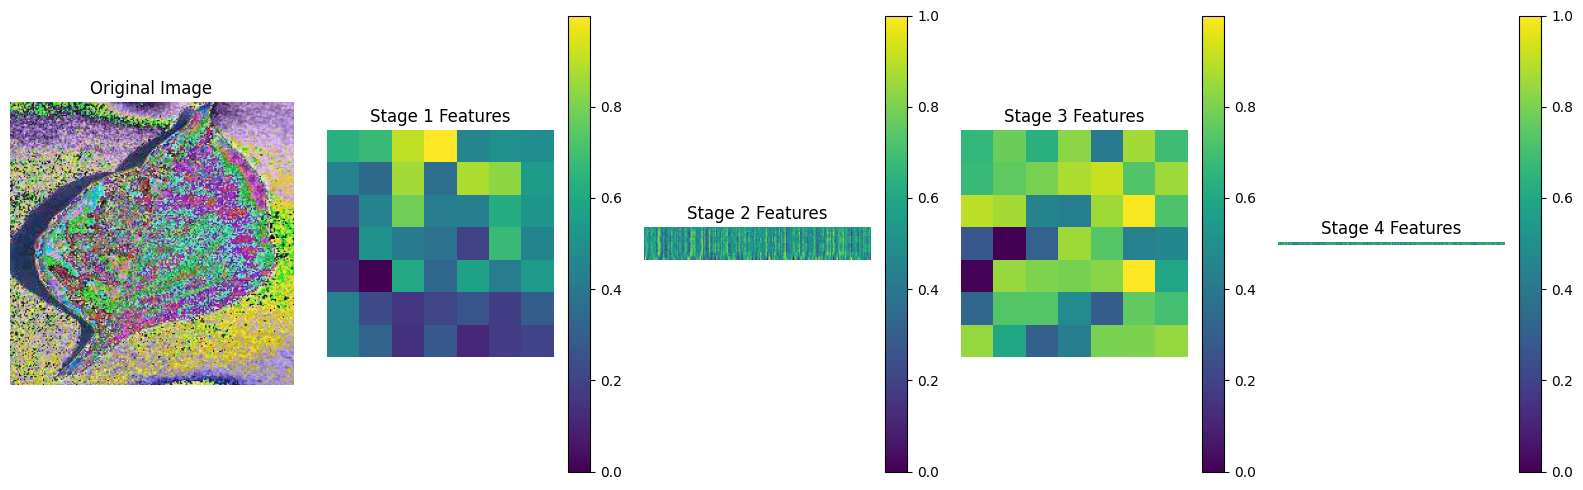

Predicted class: Pepper__bell___Bacterial_spot


In [ ]:
# Example usage of attention visualization
print("\n4. Swin Transformer Attention Visualization")
try:
    pred_label = visualize_swin_attention_windows(model, img_path)
    print(f"Predicted class: {pred_label}")
except Exception as e:
    print(f"Error with attention visualization: {e}")
    # Fall back to attribution map
    try:
        pred_label = visualize_attribution_map(model, img_path)
        print(f"Predicted class: {pred_label}")
    except Exception as e:
        print(f"Error with attribution map: {e}")